<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_GRU_Avec_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type GRU associé à une couche d'attention pour réaliser des prédictions sur notre série temporelle.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle et du dataset pour l'entrainement

In [338]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset


# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit)

temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(serie,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

# Création du modèle GRU avec couche d'attention personnalisée simple

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/LSTM_1.png?raw=true" width="1200"> 

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

On créé une classe dérivée de la classe [Layer](https://keras.io/api/layers/base_layer/#layer-class) de Keras. Les méthodes utilisées sont les suivantes :  
 - [build](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#build) : Permet de créer les variables utilisées par la couche (commes les poids et les offsets)
 - [call](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#call) : Permet d'implanter la logique de la couche

In [409]:
# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim):
    self.dim = dim              # Dimension des vecteurs cachés de la couche récurrente
    super().__init__()          # Appel du __init__() de la classe Layer
  
  # Fonction appellée pour créer les variables de la couche
  # input_shape = (None, nbr_v, dim)
  #     nbr_v : Nombre de vecteurs cachés passés à la couche d'attention
  #     dim   : Dimension des vecteurs cachés de la couche récurrente
  def build(self,input_shape):
    self.nbr_v = input_shape[1]       # Nombre de vecteurs cachés passés à la couche d'attention
    self.w = self.add_weight(shape=(self.dim,1), initializer="normal", name="w")         # Initialise les poids avec une loi normale
    self.b = self.add_weight(shape=(self.nbr_v,1), initializer="zeros", name="b")        # Initialise les offsets à zéro
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    e = K.tanh(K.dot(x,self.w) + self.b)
    a = K.softmax(e,axis=1)                     # Poids d'attention
    sortie = K.sum(x*a, axis=1)                 # Vecteur d'état de sortie d'attention
    return a, sortie

In [389]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
x = tf.Variable(tf.ones([32,20,40], dtype=tf.float32))
x = initializer(shape=(32,20,40))

w = initializer(shape=(40,1))
b = initializer(shape=(20,1))


In [ ]:
e = K.dot(tf.reshape(x[0,:,:],(20,40)),w)
a = K.softmax(e,axis=0)
#print(a)
print(K.sum(tf.reshape(x[0,:,:],(20,40))*a, axis=0))

In [ ]:
e=K.dot(x,w)
a = K.softmax(e,axis=1)
s = K.sum(x*a, axis=1)
print(s)

In [ ]:
e=(K.dot(x,w))
a = K.softmax(e,axis=1)
print(K.sum(x*a, axis=0))

In [410]:
# Couche d'attention perso

dim_GRU = 40

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

inputs = tf.keras.Input(shape=(20))
encoder_output = tf.keras.layers.GRU(units=dim_GRU,return_sequences=True)(tf.keras.layers.Lambda(Traitement_Entrees)(inputs))
print(encoder_output.shape)

poids_attention, vecteur_attention = Couche_Attention(dim=dim_GRU)(encoder_output)
print(poids_attention.shape)
print(vecteur_attention.shape)

outputs = tf.keras.layers.Dense(1,trainable=True)(vecteur_attention)
out = tf.keras.layers.Lambda(Traitement_Sorties)(outputs)
model=tf.keras.Model(inputs,outputs)

model.summary()

(None, 20, 40)
(None, 20, 1)
(None, 40)
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
lambda_25 (Lambda)           (None, 20, 1)             0         
_________________________________________________________________
gru_53 (GRU)                 (None, 20, 40)            5160      
_________________________________________________________________
couche__attention_50 (Couche ((None, 20, 1), (None, 40 60        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 41        
Total params: 5,261
Trainable params: 5,261
Non-trainable params: 0
_________________________________________________________________


In [411]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
45/45 [==============================] - 2s 7ms/step - loss: 86.5573 - mae: 87.0567

Epoch 00001: loss improved from inf to 91.82028, saving model to poids.hdf5
Epoch 2/100
45/45 [==============================] - 0s 7ms/step - loss: 85.3869 - mae: 85.8865

Epoch 00002: loss improved from 91.82028 to 91.82024, saving model to poids.hdf5
Epoch 3/100
45/45 [==============================] - 0s 7ms/step - loss: 85.2055 - mae: 85.7050

Epoch 00003: loss improved from 91.82024 to 91.82021, saving model to poids.hdf5
Epoch 4/100
45/45 [==============================] - 0s 7ms/step - loss: 84.6162 - mae: 85.1157

Epoch 00004: loss improved from 91.82021 to 91.82016, saving model to poids.hdf5
Epoch 5/100
45/45 [==============================] - 0s 7ms/step - loss: 85.4993 - mae: 85.9990

Epoch 00005: loss improved from 91.82016 to 91.82010, saving model to poids.hdf5
Epoch 6/100
45/45 [==============================] - 0s 7ms/step - loss: 85.3180 - mae: 85.8175

Epoch 00006: loss 

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

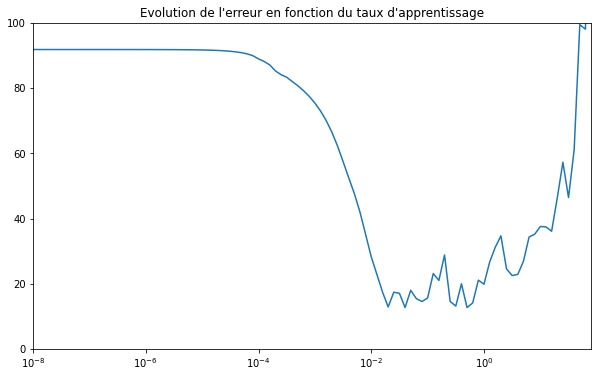

In [412]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 100])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [324]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [326]:
# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(lr=1e-3)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

Epoch 1/500
45/45 [==============================] - 3s 22ms/step - loss: 22.7784 - mae: 23.2713 - val_loss: 28.2216 - val_mae: 28.7197

Epoch 00001: loss improved from inf to 23.45444, saving model to poids.hdf5
Epoch 2/500
45/45 [==============================] - 1s 12ms/step - loss: 22.1600 - mae: 22.6542 - val_loss: 28.7467 - val_mae: 29.2440

Epoch 00002: loss improved from 23.45444 to 23.42657, saving model to poids.hdf5
Epoch 3/500
45/45 [==============================] - 1s 11ms/step - loss: 22.8616 - mae: 23.3565 - val_loss: 28.5629 - val_mae: 29.0597

Epoch 00003: loss improved from 23.42657 to 23.40776, saving model to poids.hdf5
Epoch 4/500
45/45 [==============================] - 1s 12ms/step - loss: 22.2090 - mae: 22.7019 - val_loss: 29.2484 - val_mae: 29.7452

Epoch 00004: loss improved from 23.40776 to 23.37637, saving model to poids.hdf5
Epoch 5/500
45/45 [==============================] - 1s 12ms/step - loss: 21.6049 - mae: 22.0971 - val_loss: 29.2751 - val_mae: 29.77

KeyboardInterrupt: ignored

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

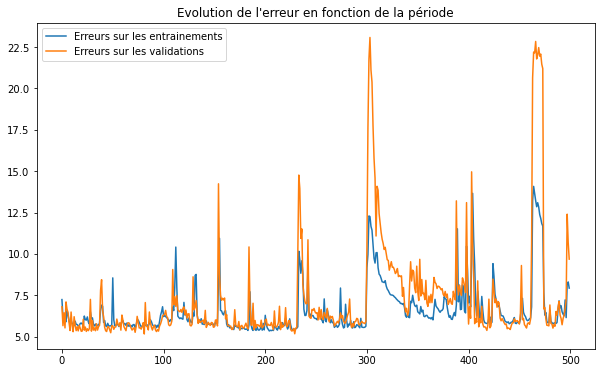

In [317]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

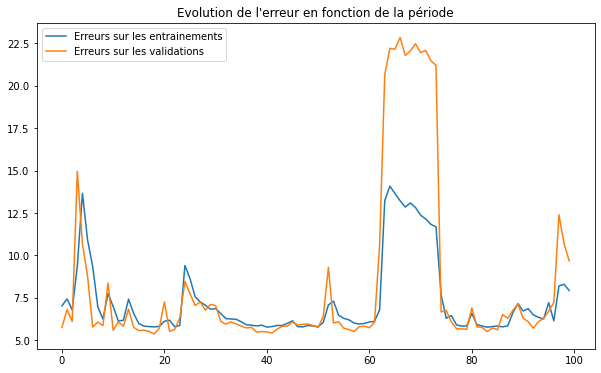

In [318]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

# Création du modèle GRU avec couche d'attention comprenant un vecteur de contexte

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Sous forme de shéma, notre réseau est donc le suivant :

In [16]:
# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self):
    super().__init__()          # Appel du __init__() de la classe Layer
  
  # Fonction appellée pour créer les variables de la couche
  # input_shape = (nbr_v, dim)
  #     dim   : Dimension des vecteurs cachés de la couche récurrente
  #     nbr_v : Nombre de vecteurs cachés passés à la couche d'attention
  def build(self,input_shape):
    self.dim = input_shape[1]         # Dimension des vecteurs cachés de la couche récurrente
    self.nbr_v = input_shape[0]       # Nombre de vecteurs cachés passés à la couche d'attention
    
    self.W = self.add_weight(shape=(self.dim,self.dim), initializer="normal", name="W")         # Initialise les poids avec une loi normale
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    return 1

In [ ]:
#x = K.placeholder((2,2))
x = tf.keras.backend.random_uniform_variable(shape=(3, 4), low=0, high=1)
Couche_Attention()(x)
Couche_Attention().get_weights()

<KerasTensor: shape=(2, 2) dtype=float32 (created by layer 'input_1')>